## Classifying two similar slope that has a very small difference

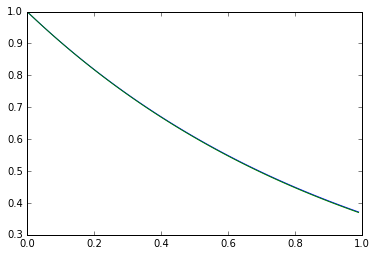

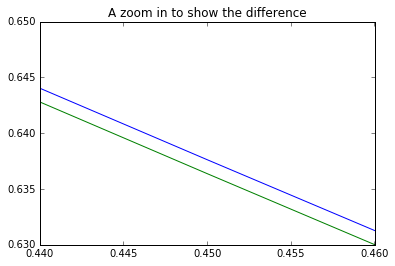

In [8]:
import numpy as np
import matplotlib.pyplot as plt

Ratio = np.random.rand(3)
Ratio = Ratio/sum(Ratio)

x = np.arange(0,1,0.01)
y = np.exp(-x)

y1 = Ratio[0]*np.exp(-(x+0.002*x))+Ratio[1]*np.exp(-(x+x*0.007))+Ratio[2]*np.exp(-x)

plt.figure()
plt.plot(x,y)
plt.plot(x,y1)
plt.show()

plt.figure()
plt.title("A zoom in to show the difference")
plt.plot(x,y)
plt.plot(x,y1)
plt.xlim(0.44,0.46)
plt.ylim(0.63,0.65)
plt.show()

Adding Noise to both function.

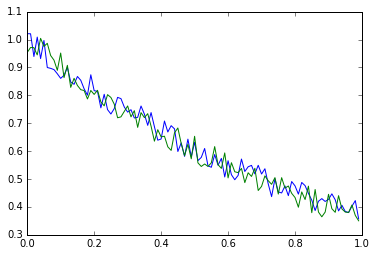

In [10]:
noise = 0.1

y_noise = (np.random.rand(len(x))*noise-noise/2.)+y
y1_noise = (np.random.rand(len(x))*noise-noise/2.)+y1

plt.figure()
plt.plot(x,y_noise)
plt.plot(x,y1_noise)
plt.show()

Generating the data

In [21]:
n = 10000
no_of_x = 100

def x_generator(n):
	input_x = np.zeros((n,no_of_x))
	for i in range(n):
		input_x[i] = np.arange(0,1,0.01)
	return input_x

x_axis = x_generator(n)

def beta(x):
	yall = np.zeros((n,no_of_x))
	for i in range(n):
		yall[i] = np.exp(-x[i]) + (np.random.rand(no_of_x)*noise - noise/2.)

	return yall

def gamma(x):
	yall = np.zeros((n,no_of_x))
	for i in range(n):
		ratio = np.random.rand(3)
		ratio = ratio/sum(ratio)
		shift = np.random.rand(2)/no_of_x
		yall[i] = ratio[0]*np.exp(-(x[i]+shift[0]*x[i])) + ratio[1]*np.exp(-(x[i]+shift[1]*x[i])) + ratio[2]*np.exp(-x[i])
		yall[i] = yall[i] + (np.random.rand(no_of_x)*noise - noise/2.)
	return yall

x1 = beta(x_axis)
x2 = gamma(x_axis)

print(x1.shape,x2.shape)

(10000, 100) (10000, 100)


Some method to augment the data into 2 dimensional space, Grammian matrix, Stochastic Matrix, Statsmodel.ARIMA

However all methods only leads to ~50% accuracy -> Fail to learning any structure.

### Grammian Matrix

1) rescale data from -1 to 1

2) Transform into Polar coordinate

3) Form grammian matrix with cos function

In [ ]:
import math
def resecale_1to1(pmtall):
	x = pmtall
	w,h = x.shape
	print(w,h)
	y = np.zeros((w,h))
	x_max = np.amax(x, axis = 1)
	x_min = np.amin(x, axis = 1)
	for i in range(len(x)):
		for j in range(len(x[i])):
			y0 = (x[i][j])
			y1 = x_min[i]
			y2 = x_max[i]
			y[i][j] = ((y0-y2)+(y0 - y1))/(y2 - y1)
	return y


def polar(pmtall):
	x = pmtall
	w,h = x.shape
	print("polar!!")
	r = np.zeros((w,h))
	# phi = np.zeros((w,h))
	for i in range(len(x)):
		j = len(x[i])
		for k in range(len(x[i])):
			y = x[i][k]
			r[i][k] = math.acos(y)*2 - math.pi
			# phi[i][k] = k/j

	return r

def gram_matrix(pmtall):
	x = pmtall
	w,h = x.shape
	print("gramian!")
	y = np.zeros((w,h,h))
	for i in range(w):
		for j in range(h):
			for k in range(h):
				ele1 = x[i][j]
				ele2 = x[i][k]
				y[i][j][k] = math.sin(ele1+ele2)
		# plt.imshow(y[i], interpolation="nearest")
		# plt.show()

	return y
x1 = beta(x_axis)
x2 = gamma(x_axis)
# x1_1 = resecale_1to1(x1)
# x2_1 = resecale_1to1(x2)
# polar_coor_beta = polar(x1_1)
# polar_coor_gamma = polar(x2_1)
# gram_beta = gram_matrix(polar_coor_beta)
# gram_gamma = gram_matrix(polar_coor_gamma)


### Stochastic Matrix

A Markov Transition Matrix

In [ ]:
from sklearn.preprocessing import normalize

def stochastic(x):
	w,h = x.shape
	Matrix = np.zeros((w,h,h))
	for i in range(w):
		bins = np.arange(0, 1, 0.01)
		inds = np.digitize(x[i], bins, right=True)

		lags = np.zeros((2,len(inds)-1))
		for y in range(len(inds)-1):
			lags[0][y] = inds[y]
			lags[1][y] = inds[y+1]

		MTM = np.zeros((len(bins),len(bins)))
		for y in range(len(bins)):
			for z in range(len(bins)):

				dummy = 0
				for p in range(len(lags[0])):
					if lags[0][p] == y and lags[1][p] == z :
						dummy += 1
				MTM[y][z] = dummy
		MTM = normalize(MTM,norm="l1")
		MTM = np.flipud(MTM)
		Matrix[i] = MTM
	return Matrix


### ARIMA in python.statsmodels

Cannot find a definitive difference

In [ ]:
mport statsmodels.api as sm

def sm_arima(x):
	yall = np.zeros((n,99))
	for i in range(len(x)):
		dummy = sm.tsa.ARIMA(x[i], order=(2,2,0))
		arima = dummy.fit(disp=0)
		# print(arima.arparams)
		# print(arima.pvalues)
		# print(arima.arfreq)
		# print(arima.aic)
		# print(arima.bic)
		# print(arima.bse)
		# print(arima.fittedvalues)
		for j in range(len(arima.fittedvalues)):
			yall[i][j] = arima.resid[j]
		# print("\n entry = ",i)
		# print(arima.summary())
		# print(arima.tvalues)
		# print(len(arima.resid))

		# yall[i][0] = np.array(arima.arparams)
		# yall[i][1] = arima.pvalues[0]
		# yall[i][2] = arima.pvalues[1]
		# yall[i][3] = arima.pvalues[2]		
		# yall[i][3] = arima.arfreq
		# yall[i][0] = arima.aic
		# yall[i][1] = arima.bic
		# yall[i][6] = arima.bse[0]
		# yall[i][7] = arima.bse[1]
		# yall[i][2] = arima.hqic
		# if i >20:
			# break
	return yall

### A Clear demonstration of the failure to recognized which was expected.

In [20]:
def separation(x,ratio):
	train = np.zeros((int(len(x)*ratio),no_of_x))
	test = np.zeros((int(len(x)*(1.-ratio)),no_of_x))
	for i in range(n):
		if i < (n*ratio):
			train[i] = x[i]
		if i >= (n*ratio):
			k = i - int(n*ratio) - 1
			test[k] = x[i]
	return train, test

train_beta, test_beta = separation(x1,0.5)
train_gamma, test_gamma  = separation(x2,0.5)

def labelling(x,num):
	label = np.zeros(len(x))
	for i in range(len(x)):
		label[i] = num
	return label

label_train_beta = labelling(train_beta,1)
label_train_gamma = labelling(train_gamma,0)
label_test_beta = labelling(test_beta,1)
label_test_gamma = labelling(test_gamma,0)

data_train = np.concatenate((train_beta,train_gamma), axis=0)
data_test = np.concatenate((test_beta,test_gamma), axis=0)
label_train = np.concatenate((label_train_beta,label_train_gamma),axis=0)
label_test = np.concatenate((label_test_beta,label_test_gamma),axis=0)

# data_train = np.expand_dims(data_train,axis=2)
data_train = np.expand_dims(data_train,axis=3)
# data_test = np.expand_dims(data_test,axis=2)
data_test = np.expand_dims(data_test,axis=3)

import keras

label_train = keras.utils.to_categorical(label_train, 2)
label_test = keras.utils.to_categorical(label_test, 2)

from keras.models import Model, Sequential, load_model
from keras.layers import Input, Dense, Activation, Conv1D, MaxPooling1D, Dropout, Flatten, BatchNormalization

from keras.regularizers import l2
from keras.optimizers import SGD

model = Sequential()
model.add(Conv1D(32, kernel_size=3, activation="relu", input_shape=(no_of_x,1)))
model.add(Conv1D(64, 3, activation="relu"))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128,activation="relu"))
# model.add(Dense(256,activation="relu"))
# model.add(Dense(512,activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(2,activation="softmax"))
model.summary()
model.compile(loss = keras.losses.categorical_crossentropy, optimizer = keras.optimizers.Adadelta(), metrics=['accuracy'])
model.fit(data_train, label_train, batch_size=50, epochs=30, verbose=1, validation_data=(data_test,label_test))
score = model.evaluate(data_test, label_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:34: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_8 (Conv1D)            (None, 98, 32)            128       
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 96, 64)            6208      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 48, 64)            0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 48, 64)            0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 128)               393344    
_________________________________________________________________
dropout_14 (Dropout)         (None, 128)               0         
__________

# Looking into methods of classifying small difference - Mission Impossible

I am still looking for ways to classiying noised functions with small difference as doing so can allows us to bring a new prespective to classifying physics data at the raw data level. Tradionally it is done through the reconstruction of physical parameters from raw data where "information" is lost in doing so. Attempt to simplify and speed the classification task of "signal" and "background".

## Possible Ideas, Wild concepts

This is a problem I feel worth researching and overcome as ML technique will then be much more superior to Pulse Shape Discriminator where traditional classification between gamma events and beta events are not clear due to the small difference/indentity both of it. In many way we can also translate this capablilty to other aspect that requires separation between not obvious difference where complicated techniques are required.